## Step-by-step visualization of the spur gear measurement

### Nominals generated by M3

Let's read every nominal flank curve and store them in a dataframe.

In [907]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline
import os
import re

In [908]:
basePath = "D:\\development\\m3_stuff\\m3_traditional2\\M3\\branches\\M3Hybrid64\\m3\\M3\\data\\ggfx"

In [909]:
filenamePattern = '(left|right)_nominals_([0-9]*)\.txt'
filenamePattern = re.compile(filenamePattern)

nominals = None

with os.scandir(basePath) as entries:
    for entry in entries:
        m = filenamePattern.match(entry.name)
        if m == None or (not entry.is_file()):
            continue
        side = m.group(1)
        toothId = m.group(2)
        #print("Found {} nominal profile for tooth {}: {}".format(m.group(1), m.group(2), entry.path))
        partNominals = pd.read_csv(entry.path,
                                  delimiter=' ', header=None, 
                                   names=['x', 'y', 'z', 'dirx', 'diry', 'dirz']).drop(columns=['z', 'dirz'])
        partNominals['angle'] = np.arctan2(partNominals['y'], partNominals['x']) + 2 * np.pi
        partNominals.loc[partNominals['angle'] >= 2 * np.pi, 'angle'] = partNominals.loc[partNominals['angle'] >= 2 * np.pi, 
                                                                                         'angle'] - 2 * np.pi
        partNominals['distance'] = np.sqrt(partNominals['x'] ** 2 + partNominals['y'] ** 2)
        partNominals['side'] = side
        partNominals['source'] = 'nominal'
        partNominals['tooth_id'] = np.int32(toothId)
        
        if type(nominals) == pd.DataFrame:
            nominals = pd.concat([nominals, partNominals], sort=False)
        else:
            nominals = partNominals
        
nominals.reset_index(drop=True, inplace=True)

Total point count in nominals:

In [910]:
nominals.shape[0]

612

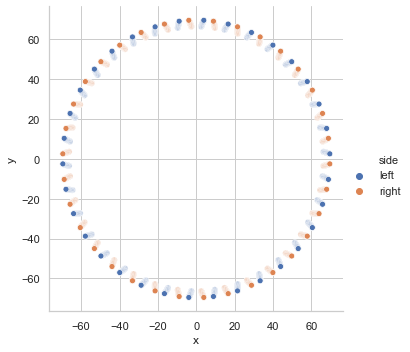

In [911]:
sns.relplot(kind='scatter', x='x', y='y', hue='side', data=nominals)

#### Pitch nominals

Let's extract the nominal points lying at the pitch radius.

In [912]:
r = 68.0

In [913]:
precision = 1e-4
pitchNominals = nominals.query('abs(distance - {}) < {}'.format(r, precision)).copy()
pitchNominals['source'] = 'pitch_nominal'

In [914]:
pitchNominals.sort_values(by='angle', inplace=True)

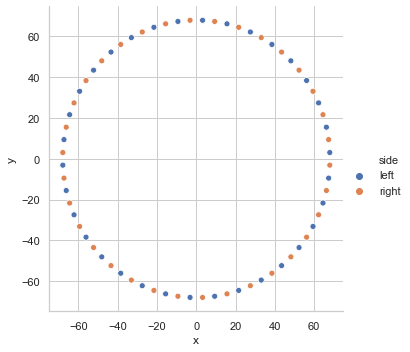

In [915]:
sns.relplot(kind='scatter', x='x', y='y', hue='side', data=pitchNominals)

### Actuals

Let's read the actuals projected onto the support plane.

In [916]:
#filenamePattern = '([0-9]+)_([0-9]+)_P_([0-9]+)_([LR])\.txt'
filenamePattern = 'actual_(.+)_([0-9]+)\.txt'
filenamePattern = re.compile(filenamePattern)

splineActuals = None

with os.scandir(basePath) as entries:
    for entry in entries:
        m = filenamePattern.match(entry.name)
        if m == None or (not entry.is_file()):
            continue
        
        #side = 'left' if m.group(4) == 'L' else 'right'
        side = m.group(1)
        toothId = np.int32(m.group(2))
        #print("{} {}".format(toothId, side))
        
        splineActualsPart = pd.read_csv(entry.path, delimiter = ' ', header=None,
                                    names=['x', 'y'])
        
        splineActualsPart['angle'] = np.arctan2(splineActualsPart['y'], splineActualsPart['x']) + 2 * np.pi
        splineActualsPart.loc[splineActualsPart['angle'] >= 2 * np.pi, 'angle'] = splineActualsPart.loc[
            splineActualsPart['angle'] >= 2 * np.pi, 'angle'] - 2 * np.pi
        splineActualsPart['distance'] = np.sqrt(splineActualsPart['x'] ** 2 + splineActualsPart['y'] ** 2)
        splineActualsPart['side'] = side
        splineActualsPart['source'] = 'spline_actual'
        splineActualsPart['tooth_id'] = np.int32(toothId)
        
        if type(splineActuals) == pd.DataFrame:
            splineActuals = pd.concat([splineActuals, splineActualsPart], sort=False)
        else:
            splineActuals = splineActualsPart

In [917]:
pd.unique(splineActuals['tooth_id'])

array([ 0,  1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29,  3, 30, 31, 32, 33,  4,  5,  6,  7,  8,  9],
      dtype=int64)

Number of points in the raw actuals:

In [918]:
splineActuals.shape[0]

612

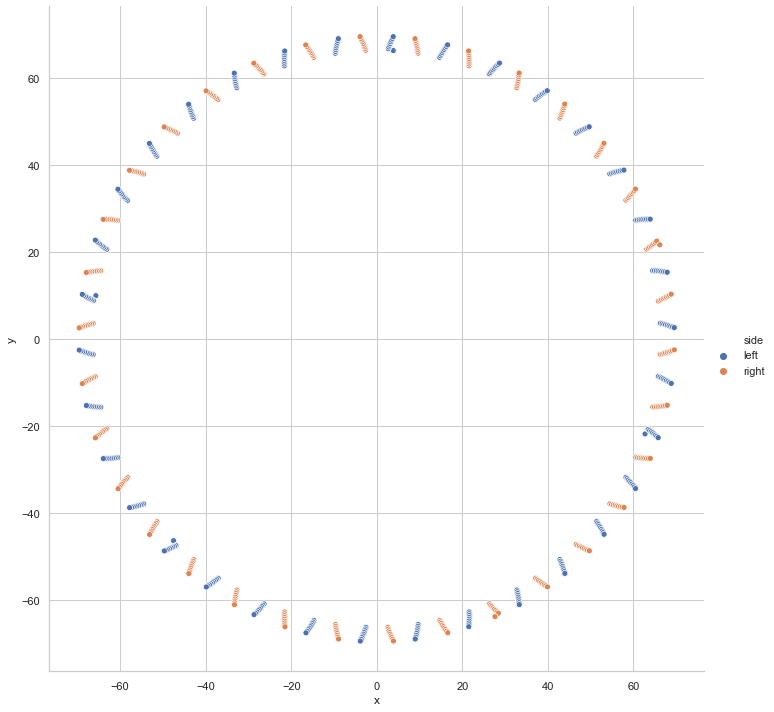

In [919]:
sns.relplot(kind='scatter', x='x', y='y', hue='side', data=splineActuals, height=10, aspect=1)

Now we read the pitch actuals.

In [920]:
actualPitchLeft = pd.read_csv(os.path.join(basePath, "actual_pitch_left.txt"),
                             delimiter=',', header=None, names=['tooth_id', 'x', 'y'])
actualPitchLeft['side'] = 'left'
actualPitchRight = pd.read_csv(os.path.join(basePath, "actual_pitch_right.txt"),
                             delimiter=',', header=None, names=['tooth_id', 'x', 'y'])
actualPitchRight['side'] = 'right'
actualPitch = pd.concat((actualPitchLeft, actualPitchRight), sort=False)

In [921]:
actualPitch['angle'] = np.arctan2(actualPitch['y'], actualPitch['x']) + 2 * np.pi
actualPitch.loc[actualPitch['angle'] >= 2 * np.pi, 'angle'] = actualPitch.loc[actualPitch['angle'] >= 2 * np.pi, 
                                                                              'angle'] - 2 * np.pi
actualPitch['distance'] = np.sqrt(actualPitch['x'] ** 2 + actualPitch['y'] ** 2)
actualPitch['source'] = 'pitch_actual'

In [922]:
actualPitch.sort_values(by='angle', inplace=True)

In [923]:
actualRaw = pd.read_csv(os.path.join(basePath, "entire_flank.txt"),
                             delimiter=' ', header=None, names=['x', 'y'])

In [924]:
#sns.relplot(kind='scatter', x='x', y='y', data=actualRaw, height=10, aspect=1)

In [925]:
actualRaw['angle'] = np.arctan2(actualRaw['y'], actualRaw['x']) + 2 * np.pi
actualRaw.loc[actualRaw['angle'] >= 2 * np.pi, 'angle'] = actualRaw.loc[actualRaw['angle'] >= 2 * np.pi, 
                                                                              'angle'] - 2 * np.pi
actualRaw['distance'] = np.sqrt(actualRaw['x'] ** 2 + actualRaw['y'] ** 2)
actualRaw['source'] = 'actual_raw'

In [926]:
allActuals = pd.concat((actualRaw, splineActuals, actualPitch), sort=False)

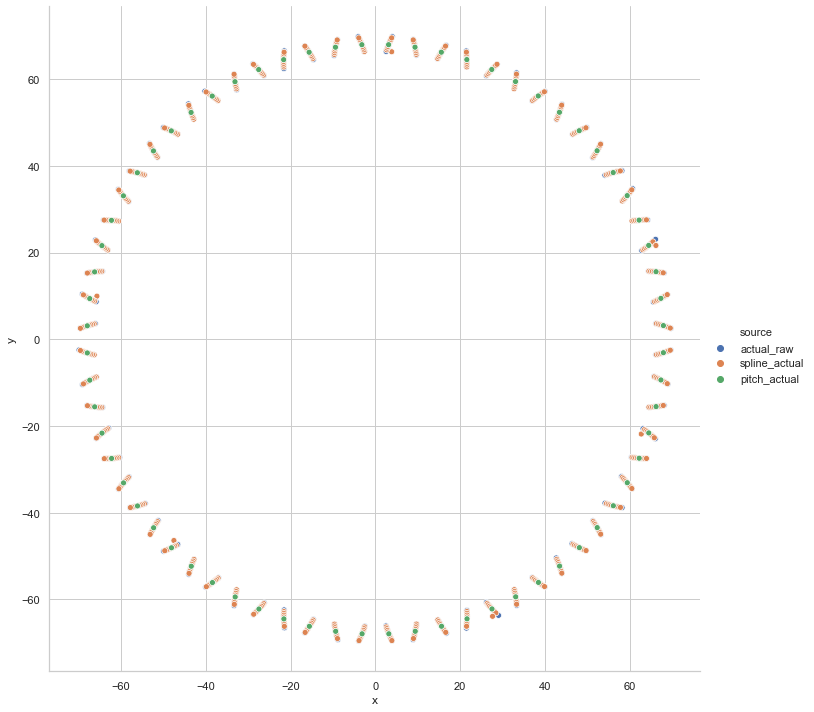

In [927]:
sns.relplot(kind='scatter', x='x', y='y', hue='source', data=allActuals, height=10, aspect=1)

In [928]:
#fg = sns.relplot(kind='scatter', x='x', y='y', hue='source', data=allActuals, height=10, aspect=1)
#axes = fg.axes
#axes[0, 0].set_xlim(65, 70)
#axes[0, 0].set_ylim(-6, 6)

In [929]:
allActuals.iloc[0]['angle']

6.229154816615004

### Tooth thickness

Function used to compute teeth thickness:

In [930]:
def computeToothThickness(pitchPoints, nominalThickness = None):
   
    def arcLen(angleA, angleB, radius):
        return (angleB - angleA) * radius;

    teethNumber = np.int32(pitchPoints.shape[0] / 2)
    #print("teeth: {}".format(teethNumber))
    toothThicknessValues = pd.DataFrame.from_dict({ 'tooth_id': np.zeros((teethNumber,), dtype=np.int32), 
                                            'width': np.zeros((teethNumber,), dtype=np.float64), 
                                            'deviation': np.zeros((teethNumber,), dtype=np.float64)
                                           })
    
    for i in np.arange(0, teethNumber):
        angleA = 0.0
        distanceA = 0.0
        if i == 0:
            #angleA = pitchPoints.loc[teethNumber * 2 - 1, 'angle'] - 2 * np.pi
            angleA = pitchPoints.iloc[teethNumber * 2 - 1]['angle'] - 2 * np.pi
            distanceA = pitchPoints.iloc[teethNumber * 2 - 1]['distance']
        else:
            angleA = pitchPoints.iloc[2 * i - 1]['angle']
            distanceA = pitchPoints.iloc[2 * i - 1]['distance']
        angleB = pitchPoints.iloc[2 * i]['angle']
        distanceB = pitchPoints.iloc[2 * i]['distance']
        pitchRadius = 0.5 * (distanceA + distanceB)
        toothThickness = arcLen(angleA, angleB, pitchRadius)
        #print("Tooth {}: angles between {} and {}: pitchRadius {} arc {}".format(i, angleA, angleB, 
        #                                                                    pitchRadius, toothThickness))
        toothThicknessValues.loc[i, 'tooth_id'] = pitchPoints.iloc[2 * i]['tooth_id']
        toothThicknessValues.loc[i, 'width'] = toothThickness
        if nominalThickness:
            toothThicknessValues.loc[i, 'deviation'] = toothThickness - nominalThickness
            
    return toothThicknessValues

#### Nominals check

In [931]:
Sn = 6.19

In [932]:
nominalToothThickness = computeToothThickness(pitchNominals, Sn)

The maximum deviation is:

In [933]:
np.max(np.abs(nominalToothThickness['deviation']))

9.415535577872447e-06

#### Tooth thickness on the actuals

In [934]:
actualToothThickness = computeToothThickness(actualPitch, Sn)

In [935]:
np.max(np.abs(actualToothThickness['deviation']))

0.06951723448201363

### Comparison between nominals and actuals

In [936]:
allData = pd.concat((nominals, allActuals), sort=False)

Let's build a graph focused on tooth 0.

(-6, 6)

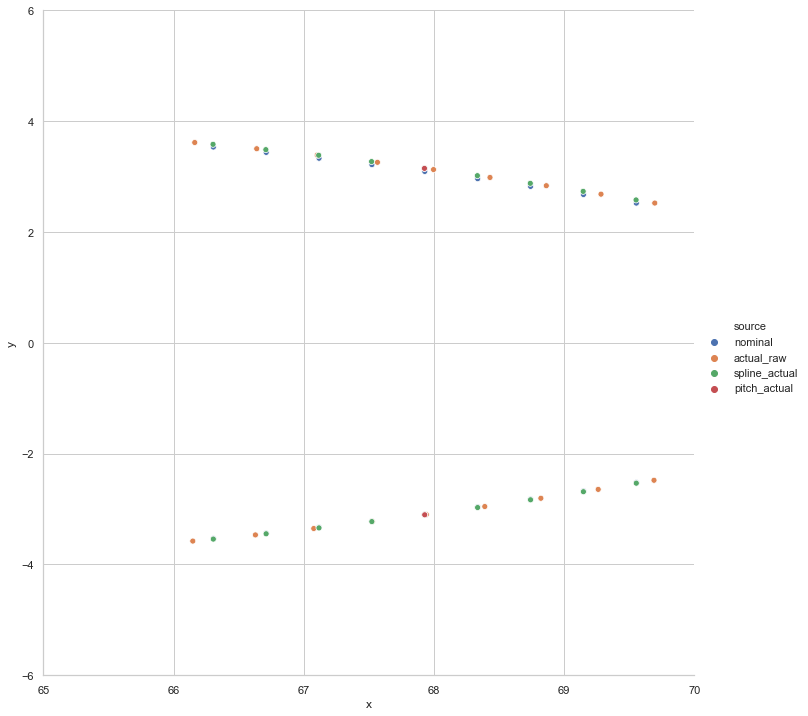

In [937]:
fg = sns.relplot(kind='scatter', x='x', y='y', hue='source', data=allData, height=10, aspect=1)
axes = fg.axes
axes[0, 0].set_xlim(65, 70)
axes[0, 0].set_ylim(-6, 6)

### Profile deviations

To compute the three types of profile deviation we will use the following function. It accepts a data frame containing the actuals (spline interpolated) and nominals.

In [938]:
def computeDeviations(actualVsNominal):

    fAlpha = None
    ffAlpha = None
    fhAlpha = None
    
    partNominal = data0.query("source == 'nominal'").sort_values(by='distance')
    partActual = data0.query("source == 'spline_actual'").sort_values(by='distance')
    
    
    # Compute total profile deviation Falpha
    # Here we build two copies of the nominal profile to enclose the actual profile.
    idMin = (partActual['y'] - partNominal['y']).idxmin()
    idMax = (partActual['y'] - partNominal['y']).idxmax()
    fAlpha = (partActual['y'][idMax] - partNominal['y'][idMax]) - (partActual['y'][idMin] - partNominal['y'][idMin])
    partNominalFalphaPlus = partNominal.copy()
    partNominalFalphaPlus['y'] = partNominalFalphaPlus['y'] + (partActual['y'][idMax] - partNominal['y'][idMax])
    partNominalFalphaPlus['source'] = 'nominal_falpha_plus' 
    partNominalFalphaMinus = partNominal.copy()
    partNominalFalphaMinus['y'] = partNominalFalphaMinus['y'] + (partActual['y'][idMin] - partNominal['y'][idMin])
    partNominalFalphaMinus['source'] = 'nominal_falpha_minus'
    
    
    # Compute profile form deviation ffalpha
    #TODO: make sure this follows the definition in the ISO
    # Here we subtract the nominal LSE straight line from the nominal profile to find its non-linear component.
    # Then we add this nominal non-linearity to the LSE straight line built for the ACTUALS.
    # This way we build a nominal-like non-linear curve around the ACTUAL LSE line.
    # The two copies of this curves have to enclose the actual profile.
    def flinear(x, A, B):
        return A * x + B
    
    a = curve_fit(flinear, partActual['distance'].values, partActual['y'].values)[0]
    partLinear = partActual.copy()
    partLinear['y'] = (a[0] * partActual['distance'] + a[1])
    partLinear['source'] = 'linear'

    
    actualNonLinear = partActual.copy()
    actualNonLinear['y'] = partActual['y'] - partLinear['y']
    actualNonLinear['source'] = 'actual_nonlinear'
    a2 = curve_fit(flinear, partNominal['distance'].values, partNominal['y'].values)[0]
    nominalNonLinear = partNominal.copy()
    nominalNonLinear['y'] = partNominal['y'].values - a2[0] * partNominal['distance'].values - a2[1]
    #print(actualNonLinear['y'])
    nominalNonLinear['source'] = 'nominal_nonlinear'
    
    actualLseNominalNonLinear = partActual.copy()
    actualLseNominalNonLinear['y'] = partLinear['y'] + nominalNonLinear['y']
    actualLseNominalNonLinear['source'] = 'actual_linear_nominal_nonlinear'
    
    idMin = (partActual['y'] - actualLseNominalNonLinear['y']).idxmin()
    idMax = (partActual['y'] - actualLseNominalNonLinear['y']).idxmax()
    
    ffAlpha = (partActual['y'] - actualLseNominalNonLinear['y'])[idMax] - (partActual['y'] - actualLseNominalNonLinear['y'])[idMin]
    
    partNominalFfalphaPlus = actualLseNominalNonLinear.copy()
    partNominalFfalphaPlus['y'] = partNominalFfalphaPlus['y'] + (partActual['y'] - 
                                                                              actualLseNominalNonLinear['y'])[idMax]
    partNominalFfalphaPlus['source'] = 'nominal_ffalpha_plus'
    partNominalFfalphaMinus = actualLseNominalNonLinear.copy()
    partNominalFfalphaMinus['y'] = partNominalFfalphaMinus['y'] + (partActual['y'] - 
                                                                                 actualLseNominalNonLinear['y'])[idMin]
    partNominalFfalphaMinus['source'] = 'nominal_ffalpha_minus'
    
    # Compute profile slope deviation fHalpha
    # Here we build two copies of the nominal curve passing through the endpoints of the actual LSE line.
    idMax = 0
    idMin = 0
    if ((partLinear['y'][0] - partNominal['y'][0]) 
        > (partLinear['y'][partLinear.shape[0] - 1] - partNominal['y'][partLinear.shape[0] - 1])):
        idMax = 0
        idMin = partLinear.shape[0] - 1
    else:
        idMax = partLinear.shape[0] - 1
        idMin = 0
        
    fhAlpha = (partLinear['y'][idMax] - partNominal['y'][idMax]) - (partLinear['y'][idMin] - partNominal['y'][idMin])
    
    partNominalFhalphaPlus = partNominal.copy()
    partNominalFhalphaPlus['y'] = partNominal['y'] + (partLinear['y'][idMax] - partNominal['y'][idMax])
    partNominalFhalphaPlus['source'] = 'nominal_fhalpha_plus'
    partNominalFhalphaMinus = partNominal.copy()
    partNominalFhalphaMinus['y'] = partNominal['y'] + (partLinear['y'][idMin] - partNominal['y'][idMin])
    partNominalFhalphaMinus['source'] = 'nominal_fhalpha_minus'
    
    
    
    actualVsNominal = pd.concat((actualVsNominal, 
                                 partNominalFalphaPlus, partNominalFalphaMinus,
                                 partNominalFfalphaPlus, partNominalFfalphaMinus, partLinear,
                                 partNominalFhalphaPlus, partNominalFhalphaMinus))
    
    return (fAlpha, ffAlpha, fhAlpha, actualVsNominal)

In [939]:
fAlpha, ffAlpha, fhAlpha, actualVsNominal = computeDeviations(data0)

#### Total profile deviation and corresponding traces

In [940]:
fAlpha

0.008496999999999755

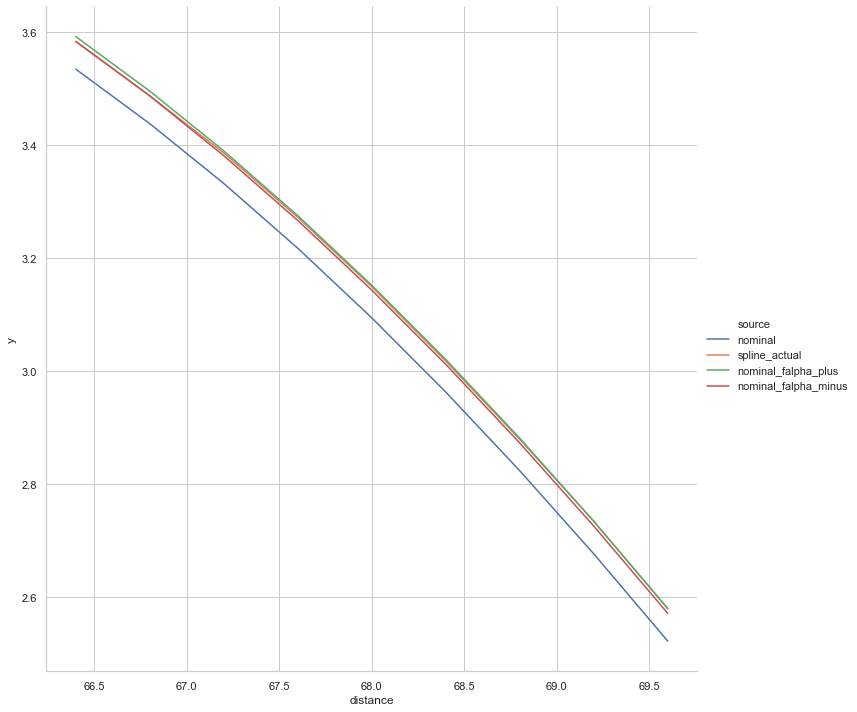

In [941]:
fg = sns.relplot(kind='line', x='distance', y='y', hue='source', 
                 data=actualVsNominal.query(
                     "source=='spline_actual' | source=='nominal' | source=='nominal_falpha_minus' | source=='nominal_falpha_plus'"), 
                 height=10, aspect=1)
axes = fg.axes
#fg.set(yscale="exp")
#axes[0, 0].set_xlim(68.5, 69.5)
#axes[0, 0].set_ylim(2.7, 3)

#### Profile form deviation and corresponding traces

In [942]:
ffAlpha

0.0034232834777254695

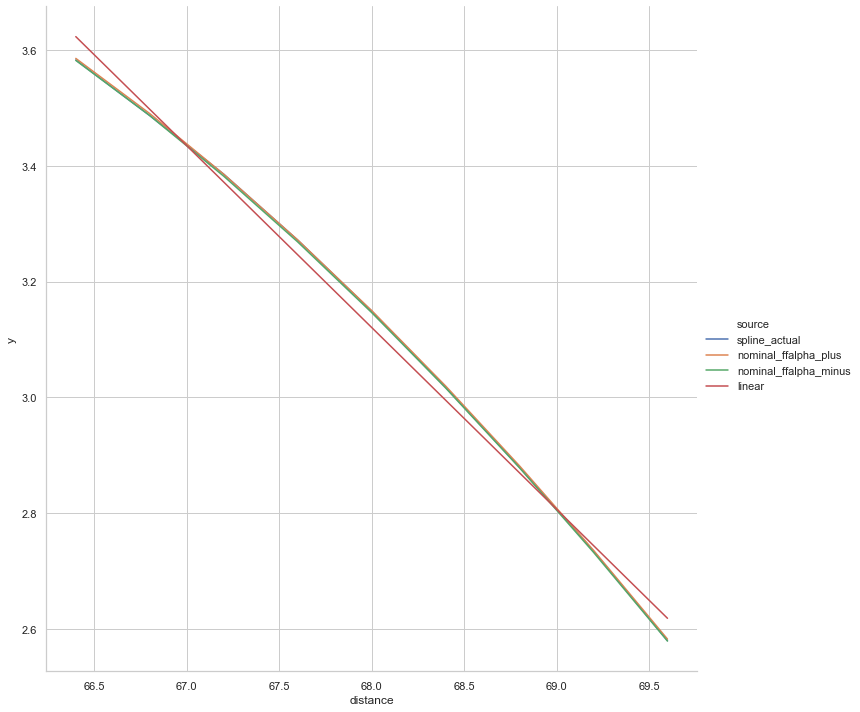

In [943]:
fg = sns.relplot(kind='line', x='distance', y='y', hue='source', 
                 data=actualVsNominal.query(
                     "source=='spline_actual' | source=='linear' | source=='nominal_ffalpha_minus' | source=='nominal_ffalpha_plus'"), 
                 height=10, aspect=1.0)
axes = fg.axes
#axes[0, 0].set_xlim(68.8, 69.2)
#axes[0, 0].set_ylim(2.7, 2.9)

#### Profile slope deviation and corresponding traces

In [944]:
fhAlpha

0.006360810151833984

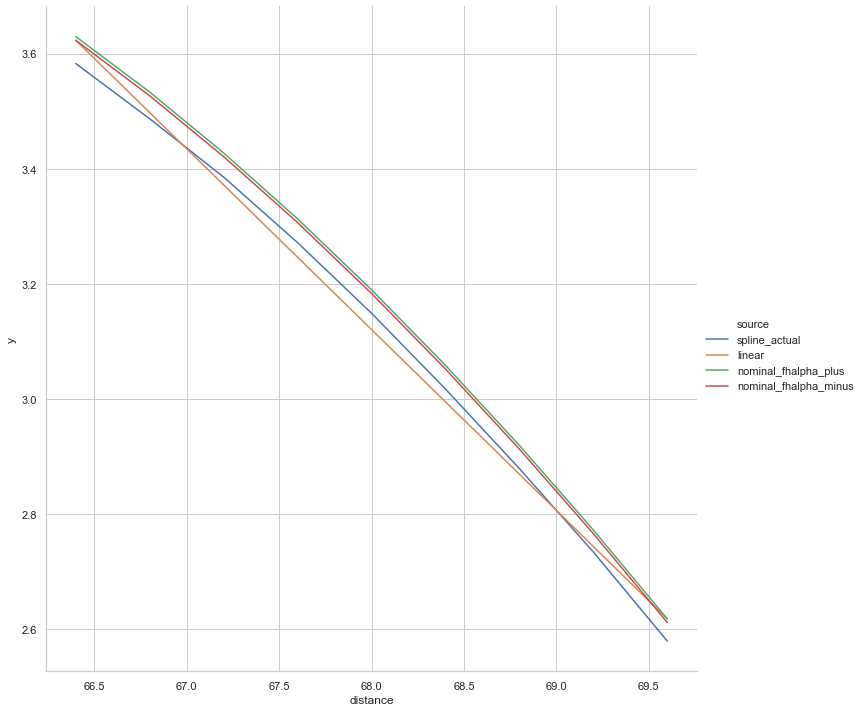

In [945]:
fg = sns.relplot(kind='line', x='distance', y='y', hue='source', 
                 data=actualVsNominal.query(
                     "source=='spline_actual' | source=='linear' | source=='nominal_fhalpha_minus' | source=='nominal_fhalpha_plus'"), 
                 height=10, aspect=1)
axes = fg.axes

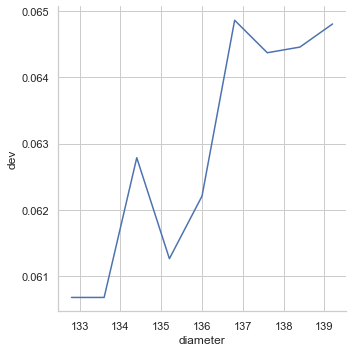

In [1013]:
m3deviations = pd.read_csv(os.path.join(basePath, "m3_gear_deviations.txt"),
                             delimiter=',', header=None, names=['diameter', 'dev', 'dev_mod_f', 'dev_mod_ff'])
sns.relplot(kind='line', x='diameter', y='dev', 
                 data=m3deviations)